In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
import glob
import geopandas as gpd
import folium

In [15]:
BASE_DIR = os.getcwd()

def build_path(*parts):
    return os.path.join(BASE_DIR, *parts)

FIELD_CONTACT_DIR = os.path.join('..', '..', 'data', 'fieldcontact')
POLICE_REQUESTS_DIR = os.path.join('..', '..', 'data', 'policerequests')
OT_EVENTS_DIR = os.path.join('..', '..', 'data', 'otevents')

# --- 📂 Load Data (assuming pre-cleaned CSVs are available) ---

# Replace with your real file paths
otevents = pd.read_csv(os.path.join(OT_EVENTS_DIR, '2019_otevents.csv'))
fc_files = glob.glob(os.path.join(FIELD_CONTACT_DIR, '*.csv'))
field_contacts = pd.concat([pd.read_csv(f) for f in fc_files], ignore_index=True)
police_requests = pd.read_csv(os.path.join(POLICE_REQUESTS_DIR, 'Police_Record_Request_Apr_1_Jun_30_2021.csv'))

In [16]:
# Overtime Events Preprocessing
def preprocess_otevents(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['OTHOURS'] = df['OTHOURS'].fillna(0)
    df['day_of_week_num'] = df['OTDATE'].dt.dayofweek
    df['start_hour'] = df['STARTTIME'].apply(lambda x: int(str(x).zfill(4)[:2]) if pd.notnull(x) else np.nan)
    df['assigned_code'] = LabelEncoder().fit_transform(df['ASSIGNED_DESC'].astype(str))
    return df

otevents = preprocess_otevents(otevents)

# Field Contacts Preprocessing
def preprocess_field_contacts(df):
    df['contact_date'] = pd.to_datetime(df['contact_date'], errors='coerce')
    df['high_risk'] = df['key_situations'].fillna('').apply(lambda x: any(word in x for word in ['Gun', 'Drugs', 'Gang', 'Shots Fired']))
    df['stop_duration'] = df['stop_duration'].fillna(df['stop_duration'].median())
    df['basis'] = df['basis'].fillna('Unknown')
    return df

field_contacts = preprocess_field_contacts(field_contacts)

# Police Requests Preprocessing
def preprocess_police_requests(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['is_civilian'] = df['RANK'].apply(lambda x: x == 'Civili')
    df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)
    df['is_covid'] = df['DESCRIPTION'].str.contains('COVID', na=False)
    df['start_hour'] = df['STARTTIME'].apply(lambda x: int(str(x).zfill(4)[:2]) if pd.notnull(x) else np.nan)
    return df

police_requests = preprocess_police_requests(police_requests)

/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_16145/3620838110.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')



--- Model: Predict Long Overtime Shift (>8 Hours) ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3223
           1       0.72      0.78      0.75       973

    accuracy                           0.88      4196
   macro avg       0.82      0.84      0.83      4196
weighted avg       0.88      0.88      0.88      4196



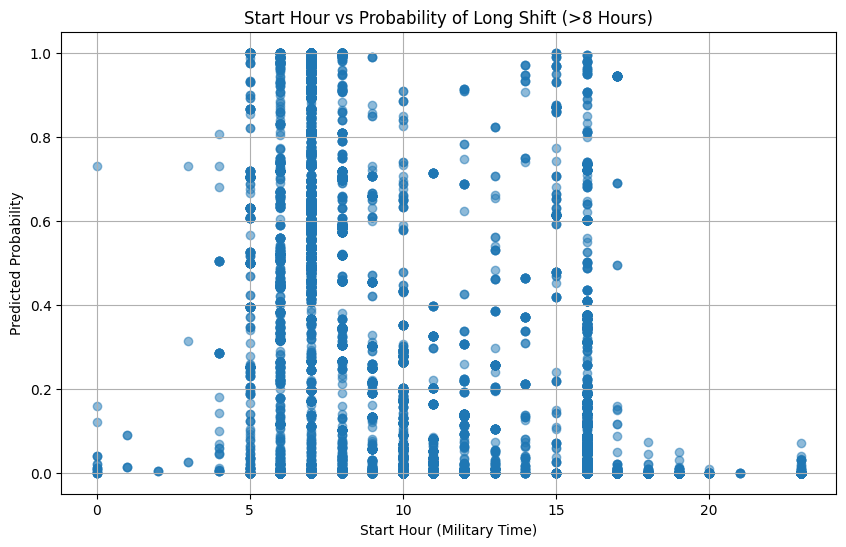

In [17]:
otevents['long_shift'] = (otevents['OTHOURS'] > 8).astype(int)

features = otevents[['day_of_week_num', 'start_hour', 'assigned_code']].dropna()
target = otevents.loc[features.index, 'long_shift']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("\n--- Model: Predict Long Overtime Shift (>8 Hours) ---")
print(classification_report(y_test, y_pred))

# Now predict probabilities for entire dataset
long_shift_probs = clf.predict_proba(features)[:, 1]

# Plot
plt.figure(figsize=(10,6))
plt.scatter(otevents.loc[features.index, 'start_hour'], long_shift_probs, alpha=0.5)
plt.title('Start Hour vs Probability of Long Shift (>8 Hours)')
plt.xlabel('Start Hour (Military Time)')
plt.ylabel('Predicted Probability')
plt.grid(True)
plt.show()
